In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext(master='local',appName="Linear Regression")
spark = SparkSession(sparkContext=sc)

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

# Gradient Descent in Python

### Generate data

In [20]:
size= 1000
x1 = np.random.rand(size)
x2 = np.random.rand(size)
beta0 = 0
beta1 = 1
beta2 = 4
x = []
for i in range(size):
    x.append(np.array([x1[i],x2[i]]))
e = np.random.rand(size)*0.2
y = beta0 + beta1*x1 + beta2*x2 + e

### Data visualisation

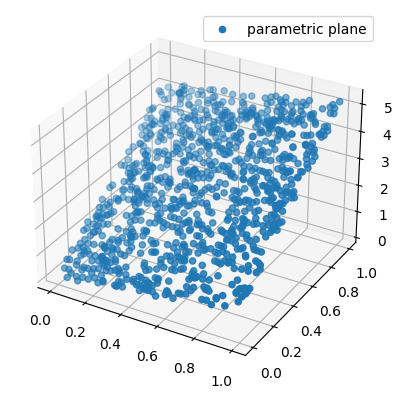

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
 
mpl.rcParams['legend.fontsize'] = 10
 
fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')

ax.scatter3D(x1, x2, y, label='parametric plane' )
ax.legend()
 
plt.show()

### Gradient Descent Algorithm

In [5]:
learningRate = 1
num_iteration = 30
m_current=np.zeros(2)
n = float(size)
# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    # Calculate the prediction with current regression coefficients. 
    cost = 0
    m_gradient = 0
    for j in range(size):
        y_prediction = np.dot(m_current,x[j])
        # We compute costs just for monitoring 
        cost += ( y[j] - y_prediction)**2
        # calculate gradients.
        m_gradient += x[j] * (y[j] - y_prediction)
    m_gradient = (-1.0/n)* m_gradient
    # update the weights - Regression Coefficients 
    m_current = m_current - learningRate * m_gradient
    print(i , "m=", m_current, " Cost=", cost/n)

0 m= [1.33759496 1.57725077]  Cost= 7.914193389009165
1 m= [1.85619167 2.32727776]  Cost= 1.760660122157365
2 m= [2.02419131 2.71197725]  Cost= 0.5535180214601758
3 m= [2.044783  2.9326877]  Cost= 0.2889338534636637
4 m= [2.0058769  3.07740671]  Cost= 0.20865687721340234
5 m= [1.94529553 3.18480874]  Cost= 0.16829949876769013
6 m= [1.87911726 3.27208519]  Cost= 0.1397113619553918
7 m= [1.8139978  3.34705318]  Cost= 0.1168621884971347
8 m= [1.75252503 3.41342369]  Cost= 0.0980227073493562
9 m= [1.69554489 3.47309489]  Cost= 0.08237562572212077
10 m= [1.64317035 3.52715175]  Cost= 0.06935829060578828
11 m= [1.59521803 3.57630285]  Cost= 0.05852461996352188
12 m= [1.55139605 3.6210724 ]  Cost= 0.04950752543909513
13 m= [1.51138398 3.66188543]  Cost= 0.042002258827723946
14 m= [1.4748659  3.69910661]  Cost= 0.035755315598328466
15 m= [1.44154337 3.73305859]  Cost= 0.03055572160882832
16 m= [1.41113966 3.76403134]  Cost= 0.02622787951527619
17 m= [1.38340036 3.79228752]  Cost= 0.02262563322

# Gradient Descent in PySpark

### Generate data
- Data range infulence the learning rate (Try to change scale_x)
- Intercept calculation (adding 1 to the input data)

In [14]:
# Now we do gradient Decent on our RDD data set. 
size  = 1000 # Size of input data
scale_x = 1 # Scaling of the input data (default range is [0,1])
d = 3 # Dimensionality of the input data
theta = [-1,1,2] # The parameters of the model
theta0 = 0 # The intercept value

# Create random input varaiables
x = np.random.rand(size,d)
# Scale the input space
x = x*scale_x

# Create the data
data = []
for i in range(size):
    # Calculate the target variable
    y = np.dot(theta,x[i]) + theta0
    # Create a tuple (target_variable, array[input_varaiables]) 
    data.append((y,x[i]))

myRDD = sc.parallelize(data)
# Needed for intercept calculation
# myRDD= myRDD.map(lambda x: (x[0],np.append(x[1],1 )))
myRDD.cache()

ParallelCollectionRDD[70] at readRDDFromFile at PythonRDD.scala:274

In [16]:
myRDD.take(3)

[(2.113336245898753, array([0.02325075, 0.98283935, 0.57687382])),
 (0.19302205625176605, array([0.06244182, 0.09880362, 0.07833013])),
 (2.4054615941233286, array([0.26556242, 0.83909118, 0.91596641]))]

### Gradient Descent Algorithm

In [18]:
learningRate = 1
num_iteration = 30

# Calculate the dimensionality of the inpit data
d_input = len(myRDD.first()[1])
beta = np.zeros(d_input)
print(f"Input dimensionalyty is {d_input} and we start wiht {beta} as parameters ")

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    gradientAndCost=myRDD.map(lambda x: (x[1], (x[0] - np.dot(x[1] , beta) )))\
                           .map(lambda x: (x[0]*x[1], x[1]**2 ))\
                           .reduce(lambda x, y: (x[0] +y[0], x[1]+y[1] ))
    cost= gradientAndCost[1]/size
    gradient=(-1/float(size))* gradientAndCost[0]
    beta = beta - learningRate * gradient
    print(f"{i} Cost:{cost:.5f} Beta {beta}")

Input dimensionalyty is 3 and we start wiht [0. 0. 0.] as parameters 
0 Cost:1.43447 Beta [0.41553784 0.54851282 0.65074756]
1 Cost:0.36355 Beta [0.38196063 0.65566583 0.84911231]
2 Cost:0.28180 Beta [0.28240876 0.68894811 0.9644713 ]
3 Cost:0.23570 Beta [0.17966414 0.70925909 1.05874069]
4 Cost:0.19768 Beta [0.08348839 0.72670407 1.14283144]
5 Cost:0.16583 Beta [-0.00508828  0.74297506  1.21914574]
6 Cost:0.13914 Beta [-0.08643347  0.75837207  1.28862315]
7 Cost:0.11676 Beta [-0.16110165  0.77296598  1.35191276]
8 Cost:0.09800 Beta [-0.22963727  0.78679086  1.40957164]
9 Cost:0.08227 Beta [-0.29254552  0.79987546  1.46210166]
10 Cost:0.06907 Beta [-0.35029066  0.8122482   1.50995913]
11 Cost:0.05800 Beta [-0.40329859  0.82393767  1.55355961]
12 Cost:0.04871 Beta [-0.45195992  0.83497258  1.5932817 ]
13 Cost:0.04092 Beta [-0.49663291  0.84538155  1.62947033]
14 Cost:0.03438 Beta [-0.53764611  0.85519292  1.66243975]
15 Cost:0.02889 Beta [-0.57530089  0.86443461  1.69247627]
16 Cost:0.0